<a href="https://colab.research.google.com/github/napjon/fastai-course-v3/blob/master/fastai-course-v3/nbs/collabs/fastai_lesson4_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai.collab import *
from fastai.tabular import *

# Collabortive Learning Example

In [0]:
user, item, title = "userId", "movieId", "title"

In [3]:
path = untar_data(URLs.ML_SAMPLE)

In [6]:
ratings = pd.read_csv(path/"ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0, 5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.598555,0.934259,00:00
1,0.858787,0.680848,00:00
2,0.650719,0.673309,00:00


#Movie Lens 100k
Let's try with the full Movielens 100k dataset

In [0]:
path = Config.data_path()/"ml-100k"

In [0]:
ratings = pd.read_csv(path/"u.data", delimiter='\t', header=None, names=[user, item, "rating", "timestamp"])

In [0]:
movies = pd.read_csv(path/"u.item", delimiter="|", encoding="latin-1", header=None, 
                     names=[item, "title", "date", "N", "url", *[f'g{i}' for i in range(19)]])

In [27]:
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [28]:
ratings.shape

(100000, 4)

In [29]:
ratings_movie = ratings.merge(movies[[item, title]])
ratings_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
# By default, Collabdatabunch.from_df takes first three columns as default Id for [user, movie, rating]
# We specify 4th column to depict product name (In this case movie title)
# Then set validation set 10% of the data
data = CollabDataBunch.from_df(ratings_movie, seed=42, valid_pct=0.1, item_name="title")

In [32]:
data.show_batch()

userId,title,target
66,Rumble in the Bronx (1995),3.0
21,She's So Lovely (1997),4.0
406,"Piano, The (1993)",4.0
321,"Postino, Il (1994)",3.0
13,Thinner (1996),1.0


Since "5" is max in typical movie ratings, and there's no way for deep learning model to achieve absolute confidence (1.0 = 5.0), we need to make the predictive output range a little bigger than it supposed to. 

In [0]:
y_range = [0, 5.5]

Next, we create the `learner` model. We use 40 latent factors, with weight decay of 0.1

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


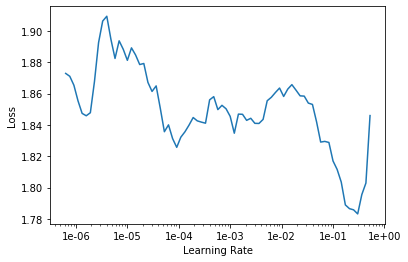

In [37]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

Since we know that the steepest fall in this curve is somewhere around 5e-2, by Jeremy Howard's best practive we move 0.1 back from it, which will result in 5e-3

In [38]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.946474,0.959127,00:10
1,0.866463,0.885076,00:10
2,0.764759,0.836304,00:10
3,0.667330,0.811135,00:10
4,0.561879,0.811289,00:09


In [0]:
learn.save('dotprod')

With this kind of accuracy, we have achieve best results that beat the current champion by the time this was written in [this benchmark](https://www.librec.net/release/v1.3/example.html).

The RMSE of the champion is 0.91, which convert back to MSE to 0.83. We are doing better with lose 0.811

In [40]:
learn.load('dotprod')

CollabLearner(data=TabularDataBunch;

Train: LabelList (90000 items)
x: CollabList
userId 196; title Kolya (1996); ,userId 63; title Kolya (1996); ,userId 226; title Kolya (1996); ,userId 154; title Kolya (1996); ,userId 306; title Kolya (1996); 
y: FloatList
3.0,3.0,5.0,3.0,5.0
Path: .;

Valid: LabelList (10000 items)
x: CollabList
userId 498; title Casino (1995); ,userId 642; title Pocahontas (1995); ,userId 58; title 2001: A Space Odyssey (1968); ,userId 495; title Cat People (1982); ,userId 618; title Philadelphia (1993); 
y: FloatList
3.0,5.0,4.0,3.0,3.0
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=FlattenedLoss of MSELoss(), metrics=[], true_wd=True, bn_wd=True, wd=0.1, train_bn=True, path=PosixPath('.'), model_dir='models', callback_fns=[functools.partial(<clas

In [41]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [53]:
top_movies = ratings_movie.title.value_counts()[:1000]
top_movies[:10]

Star Wars (1977)                 583
Contact (1997)                   509
Fargo (1996)                     508
Return of the Jedi (1983)        507
Liar Liar (1997)                 485
English Patient, The (1996)      481
Scream (1996)                    478
Toy Story (1995)                 452
Air Force One (1997)             431
Independence Day (ID4) (1996)    429
Name: title, dtype: int64

In [54]:
movie_bias = learn.bias(top_movies.index, is_item=True)
movie_bias.shape

torch.Size([1000])

In [55]:
mean_ratings = ratings_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies, movie_bias)]

TypeError: ignored